<a href="https://colab.research.google.com/github/guyyariv/DL_ex3/blob/master/main2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import copy
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import imageio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Creating data sets

In [10]:
batch_size = 100
latent_dim = 14
train_size_for_mlp = 0.0033

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)

trainset_mlp, trainset_autoencoder = torch.utils.data.random_split(trainset, [int(60000 * train_size_for_mlp), int(60000 * (1 - train_size_for_mlp))])

train_loader_mlp = DataLoader(
    trainset_mlp, batch_size=batch_size, shuffle=True
)

train_loader_autoencoder = DataLoader(
    trainset_autoencoder, batch_size=batch_size, shuffle=True
)

trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)


def calculate_accuracy(y_true, y_pred, is_training=False):
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)

    return torch.sum(y_true == y_pred) / len(y_true)

# Autoencoder architecture

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(256, latent_dim)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x).reshape((x.shape[0], 256))  # compressed representation
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.fc = nn.Linear(latent_dim, 256)
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        ## decode ##
        x = self.fc(x).reshape((x.shape[0], 4, 8, 8))
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Train Autoencoder

In [ ]:
def train_autoencoder(model, num_epochs=10, learning_rate=1e-3, trainset=trainset_autoencoder, train_loader=train_loader_autoencoder):
    model.train()
    loss_list = []
    torch.manual_seed(42)
    criterion = nn.BCELoss()  # binary cross entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    outputs = []
    for epoch in range(num_epochs):
        loss_counter = 0.0
        counter = 0
        for i, data in tqdm(enumerate(train_loader), total=int(len(trainset)/train_loader.batch_size)):
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_counter += loss.item()
            counter += 1
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss_counter / counter))
        loss_list.append(loss_counter / counter)
        outputs.append((i, img, recon),)
    plt.plot(loss_list)
    plt.legend('loss', 'epochs')
    plt.show()
    torch.save(model.encoder.state_dict(), f'encoder_model_{latent_dim}.pth')
    torch.save(model.decoder.state_dict(), f'decoder_model_{latent_dim}.pth')

    return outputs

model = ConvAutoencoder()
max_epochs = 50
outputs = train_autoencoder(model, num_epochs=max_epochs)

for k in range(0, max_epochs):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0], cmap='gray')

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0], cmap='gray')

plt.show()


  2%|▏         | 12/598 [00:00<00:35, 16.38it/s]


KeyboardInterrupt: ignored

# Decorrelation

In [14]:
latents = [5, 8, 10, 14]
result = dict()
for latent_ in latents:
    latent_dim=latent_
    encoder = Encoder()
    
    encoder.load_state_dict(copy.deepcopy(torch.load(f"encoder_model_{latent_}.pth", device)))
    trainloader = DataLoader(trainset, batch_size=1000, shuffle=True)
    for i, data in enumerate(trainloader):
        images, _ = data
        latent = encoder(images)
        if i == 0:
          break
    corr = torch.corrcoef(latent.T).detach().numpy()
    result[latent_] = np.linalg.norm(corr)
    print(result.keys())
    print(result.values())

dict_keys([5])
dict_values([2.4326987])
dict_keys([5, 8])
dict_values([2.4326987, 3.3967464])
dict_keys([5, 8, 10])
dict_values([2.4326987, 3.3967464, 3.9710805])
dict_keys([5, 8, 10, 14])
dict_values([2.4326987, 3.3967464, 3.9710805, 4.9198337])


# MLP Architecture

In [ ]:
class Mlp(nn.Module):
    def __init__(self, input_dim=latent_dim):
        super(Mlp, self).__init__()
        self.linear1 = nn.Linear(input_dim, input_dim * 2)
        self.linear2 = nn.Linear(input_dim * 2, input_dim)
        self.linear3 = nn.Linear(input_dim, input_dim)
        self.linear4 = nn.Linear(input_dim, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        return x        


# MLP + Encoder Architecture

In [ ]:
class MLPEncoder(nn.Module):

    def __init__(self):
        super(MLPEncoder, self).__init__()
        self.encoder = Encoder()
        self.mlp = Mlp()

    def forward(self, x):
        x = self.encoder(x)
        x = self.mlp(x)
        return x

# Train MLP + Encoder

In [ ]:
def train_classifier(model, train_loader, trainset, encoder, criterion, optimizer):
    model.train()
    loss_counter = 0.0
    acc_counter = 0.0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=int(len(trainset)/train_loader.batch_size)):
        img, labels = data
        if encoder:
            img = encoder(img)
        predict = model(img)
        loss = criterion(predict, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_counter += loss.item()
        acc_counter += calculate_accuracy(labels, predict).item()
        counter += 1
    return loss_counter, acc_counter, counter


def eval_classifier(model, test_loader, testset, encoder, criterion):
    model.eval()
    loss_counter = 0.0
    acc_counter = 0.0
    counter = 0
    for i, data in tqdm(enumerate(test_loader), total=int(len(testset) / test_loader.batch_size)):
        img, labels = data
        if encoder:
            img = encoder(img)
        predict = model(img)
        loss = criterion(predict, labels)
        loss_counter += loss.item()
        acc_counter += calculate_accuracy(labels, predict).item()
        counter += 1
    return loss_counter, acc_counter, counter


def classifier(model, num_epochs=10, learning_rate=1e-3, trainset=trainset_mlp, train_loader=train_loader_mlp, model_name='Mlp'):
    loss_list = []
    acc_list = []
    loss_list_test = []
    acc_list_test = []
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()  # cross entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    encoder = None
    if model_name == 'Mlp':
        encoder = Encoder()
        encoder.load_state_dict(copy.deepcopy(torch.load("encoder_model.pth", device)))
    for epoch in range(num_epochs):
        loss_counter, acc_counter, counter = train_classifier(model, train_loader, trainset, encoder, criterion, optimizer)
        loss_counter_test, acc_counter_test, counter_test = eval_classifier(model, testloader, testset, encoder, criterion)
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss_counter / counter))
        print('Epoch:{}, acc:{:.4f}'.format(epoch+1, acc_counter / counter))
        print('Epoch:{}, Loss test:{:.4f}'.format(epoch+1, loss_counter_test / counter_test))
        print('Epoch:{}, acc test:{:.4f}'.format(epoch+1, acc_counter_test / counter_test))
        loss_list.append(loss_counter / counter)
        acc_list.append(100 * acc_counter / counter)
        loss_list_test.append(loss_counter_test / counter_test)
        acc_list_test.append(100 * acc_counter_test / counter_test)
    plt.plot(loss_list)
    plt.plot(loss_list_test)
    plt.title('loss')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(acc_list)
    plt.plot(acc_list_test)
    plt.title('accuracy')
    plt.legend(['train', 'test'])
    plt.show()


model = Mlp()
max_epochs = 20
outputs = classifier(model, num_epochs=max_epochs, learning_rate=0.02, model_name='Mlp')

model = MLPEncoder()
max_epochs = 20
outputs = classifier(model, num_epochs=max_epochs, learning_rate=0.01, model_name='MLPEncoder')


# GAN Architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim=latent_dim):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(input_dim, input_dim * 2)
        self.linear2 = nn.Linear(input_dim * 2, input_dim * 2)
        self.linear6 = nn.Linear(input_dim * 2, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        print(x.shape)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear6(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(latent_dim, latent_dim * 2)
        self.linear2 = nn.Linear(latent_dim * 2, latent_dim * 2)
        self.linear6 = nn.Linear(latent_dim * 2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.sigmoid(self.linear6(x))
        return x

# Train GAN

In [ ]:
def generate_latent(number_of_images=batch_size, latent_dimension=latent_dim):
    """ Generate noise for number_of_images images, with a specific noise_dimension """
    return torch.randn(number_of_images, latent_dimension)


def generate_specific_digit(number_of_images=batch_size, digit_to_generate=0):
    zeros = torch.zeros(number_of_images)
    zeros[:] = digit_to_generate
    return zeros.to(torch.int64)


def initialize_optimizers(generator, discriminator, lr_genrator, lr_discriminator):
    """ Initialize optimizers for Generator and Discriminator. """
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_genrator, betas=(0.5, 0.999))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))
    return generator_optimizer, discriminator_optimizer

In [ ]:
batch_size=100


def train_epoch(generator, discriminator, encoder, loss_function, generator_optimizer, discriminator_optimizer):
    real_label, fake_label = 1.0, 0.0
    loss_dis = 0.0
    loss_gen = 0.0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainset)/trainloader.batch_size)):
        # train discriminator
        discriminator.zero_grad()
        img, _ = data
        real_images = encoder(img)
        label = torch.full((img.shape[0],1), real_label)
        output = discriminator(real_images)
        error_real_images = loss_function(output, label)
        error_real_images.backward()
        D_x = output.mean().item()

        latent = generate_latent(img.shape[0])
        fake = generator(latent)
        label.fill_(fake_label)
        output = discriminator(fake.detach())
        error_fake_images = loss_function(output, label)
        error_fake_images.backward()
        D_G_z1 = output.mean().item()
        errD = error_real_images + error_fake_images
        discriminator_optimizer.step()

        # train generator
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        loss_dis += errD
        loss_gen += errG
        counter += 1
    return loss_dis / counter, loss_gen / counter


def train(generator, discriminator, num_epochs=30, lr_discriminator=1e-3, lr_generator=1e-3, trainset=trainset, train_loader=trainloader):
    loss_discriminator = []
    loss_generator = []
    torch.manual_seed(42)
    encoder = Encoder()
    encoder.load_state_dict(copy.deepcopy(torch.load("encoder_model_20.pth", device)))
    criterion = nn.BCELoss()
    generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator, lr_generator, lr_discriminator)
    for epoch in range(num_epochs):
        loss_dis, loss_gen = train_epoch(generator, discriminator, encoder, criterion, generator_optimizer, discriminator_optimizer)
        print('Epoch:{}, Loss discriminator:{:.4f}'.format(epoch+1, loss_dis))
        print('Epoch:{}, Loss generator:{:.4f}'.format(epoch+1, loss_gen))
        loss_discriminator.append(loss_dis)
        loss_generator.append(loss_gen)
        generate_images(generator)
    print(loss_discriminator, loss_generator)
    plt.plot(loss_discriminator)
    plt.plot(loss_generator)
    plt.title('GAN loss')
    plt.legend(['discriminator', 'generator'])
    plt.show()
    torch.save(generator.state_dict(), 'generator.pth')
    


generator = Generator()
discriminator = Discriminator()

def generate_images(generator):
    decoder = Decoder()
    decoder.load_state_dict(copy.deepcopy(torch.load("decoder_model.pth", device)))

    latents = generate_latent()
    generate_images = generator(latents)
    print("Generate images: ", generate_images)
    outputs = decoder(generate_images[:16])

    plt.figure(figsize=(4, 4))
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    recon = outputs.detach().numpy()
    for i, item in enumerate(recon):
        if i >= 16: break
        plt.subplot(4, 4, 0+i+1)
        plt.imshow(item[0], cmap='gray')

    plt.show()


num_epochs = 2
train(generator, discriminator, num_epochs, lr_discriminator=0.0001, lr_generator=0.0001)

# Conditional GAN

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, input_dim=latent_dim):
        super(ConditionalGenerator, self).__init__()
        self.linear1 = nn.Linear(input_dim+10, input_dim * 2)
        self.linear2 = nn.Linear(input_dim * 2, input_dim * 2)
        self.linear6 = nn.Linear(input_dim * 2, latent_dim)
        self.embedding = nn.Embedding(10, 10)
        self.relu = nn.ReLU()

    def forward(self, x, labels):
        c = self.embedding(labels)
        x = torch.cat([x, c], 1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear6(x)
        return x


class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.linear1 = nn.Linear(latent_dim+10, latent_dim * 2)
        self.linear2 = nn.Linear(latent_dim * 2, latent_dim * 2)
        self.linear6 = nn.Linear(latent_dim * 2, 1)
        self.embedding = nn.Embedding(10, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, labels):
        c = self.embedding(labels)
        x = torch.cat([x, c], 1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.sigmoid(self.linear6(x))
        return x

# Train

100%|██████████| 600/600 [00:32<00:00, 18.41it/s]


Epoch:1, Loss discriminator:0.4505
Epoch:1, Loss generator:1.7737


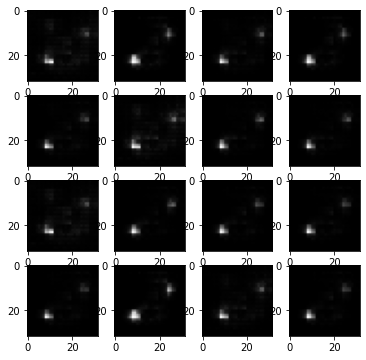

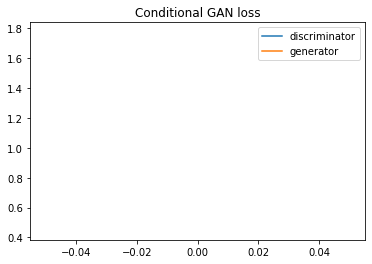

100%|██████████| 600/600 [00:32<00:00, 18.40it/s]


Epoch:2, Loss discriminator:0.1737
Epoch:2, Loss generator:3.3997


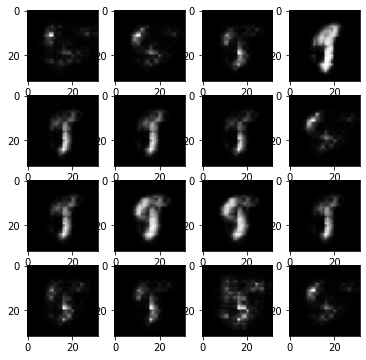

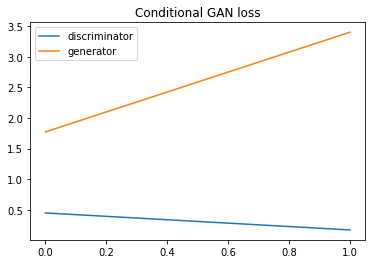

100%|██████████| 600/600 [00:32<00:00, 18.22it/s]


Epoch:3, Loss discriminator:0.1585
Epoch:3, Loss generator:3.8292


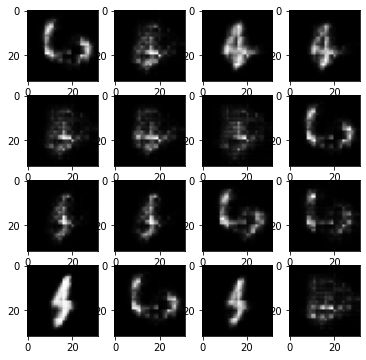

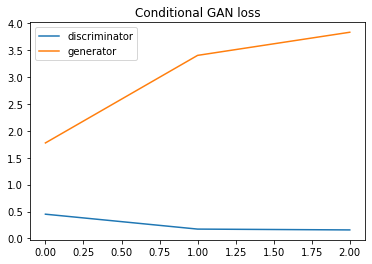

100%|██████████| 600/600 [00:33<00:00, 18.17it/s]


Epoch:4, Loss discriminator:0.2869
Epoch:4, Loss generator:3.2760


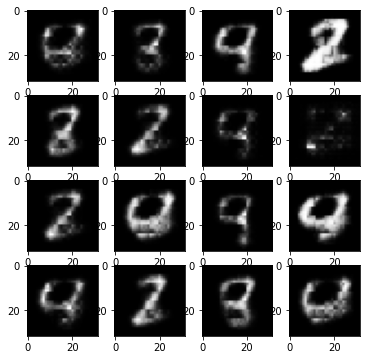

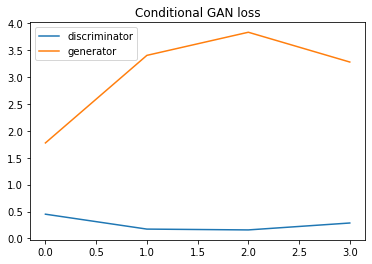

100%|██████████| 600/600 [00:33<00:00, 17.99it/s]


Epoch:5, Loss discriminator:0.2727
Epoch:5, Loss generator:3.3535


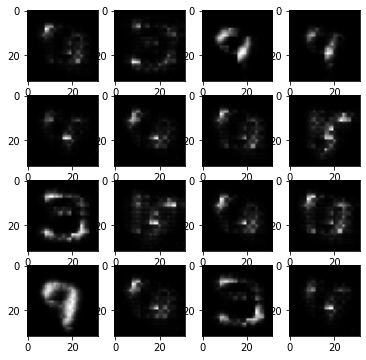

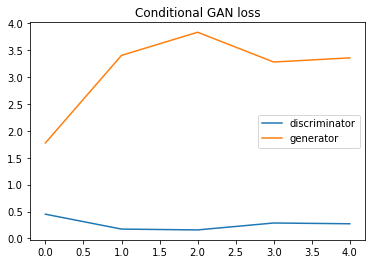

100%|██████████| 600/600 [00:33<00:00, 17.93it/s]


Epoch:6, Loss discriminator:0.3371
Epoch:6, Loss generator:3.5692


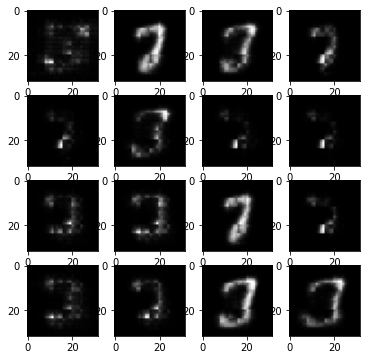

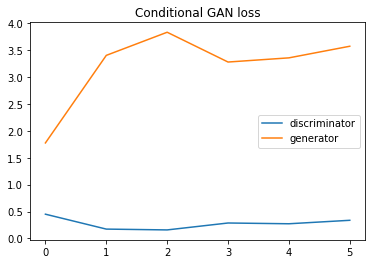

100%|██████████| 600/600 [00:33<00:00, 17.90it/s]


Epoch:7, Loss discriminator:0.3825
Epoch:7, Loss generator:2.7194


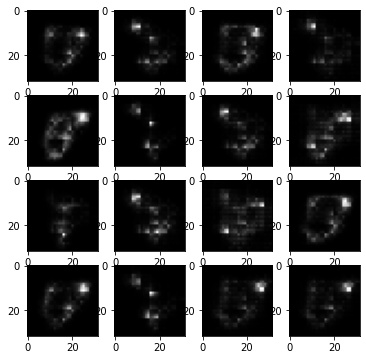

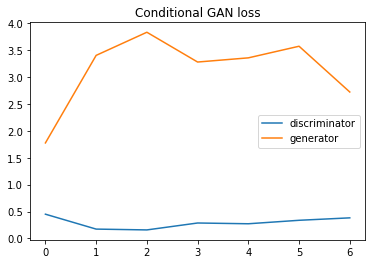

100%|██████████| 600/600 [00:33<00:00, 17.84it/s]


Epoch:8, Loss discriminator:0.3627
Epoch:8, Loss generator:2.8379


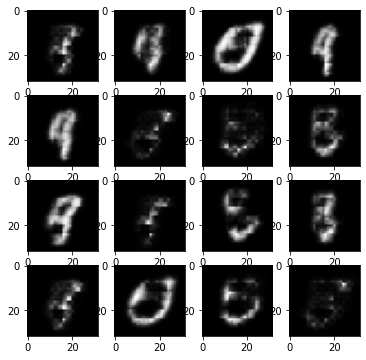

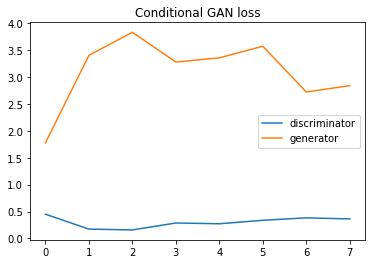

100%|██████████| 600/600 [00:33<00:00, 17.89it/s]


Epoch:9, Loss discriminator:0.3478
Epoch:9, Loss generator:3.0015


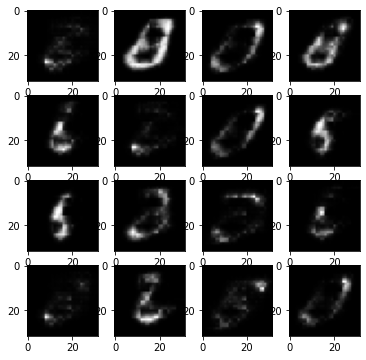

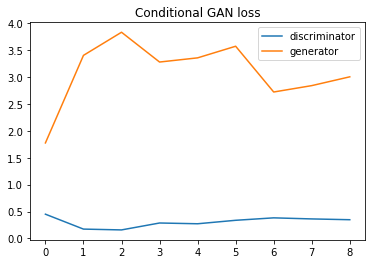

100%|██████████| 600/600 [00:33<00:00, 17.79it/s]


Epoch:10, Loss discriminator:0.3824
Epoch:10, Loss generator:3.1961


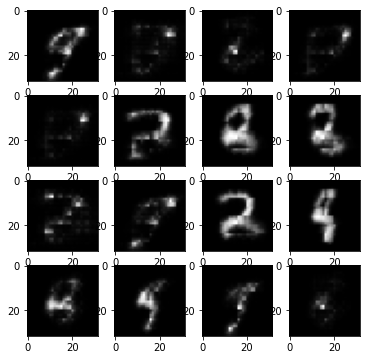

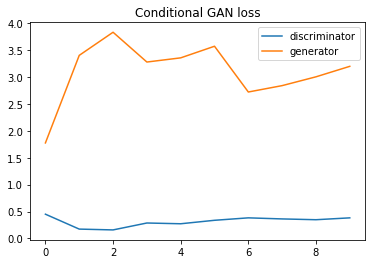

100%|██████████| 600/600 [00:34<00:00, 17.58it/s]


Epoch:11, Loss discriminator:0.4535
Epoch:11, Loss generator:2.8843


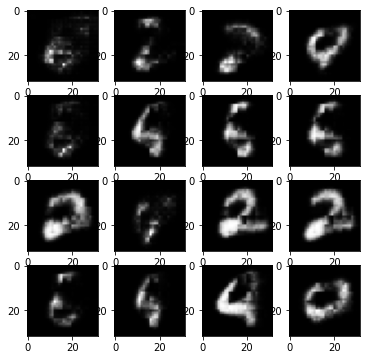

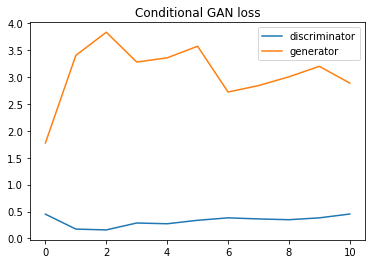

100%|██████████| 600/600 [00:34<00:00, 17.54it/s]


Epoch:12, Loss discriminator:0.4594
Epoch:12, Loss generator:2.7077


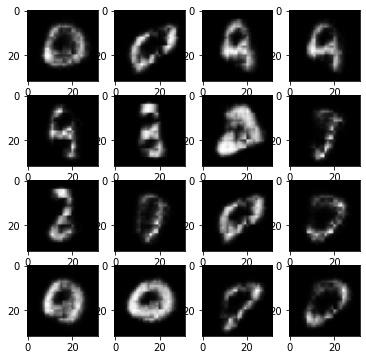

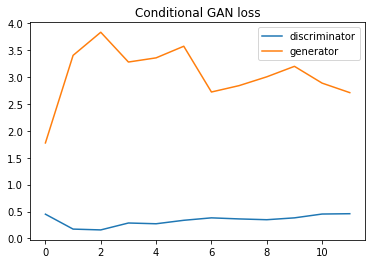

100%|██████████| 600/600 [00:34<00:00, 17.40it/s]


Epoch:13, Loss discriminator:0.6583
Epoch:13, Loss generator:2.1600


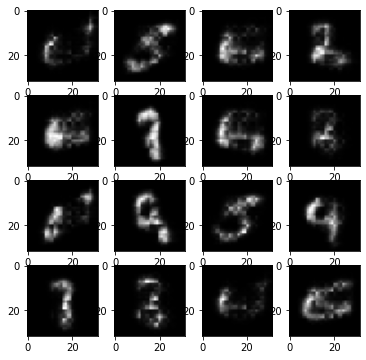

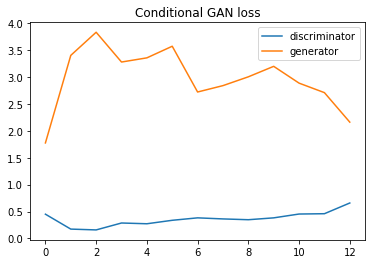

100%|██████████| 600/600 [00:35<00:00, 17.13it/s]


Epoch:14, Loss discriminator:0.6280
Epoch:14, Loss generator:1.8656


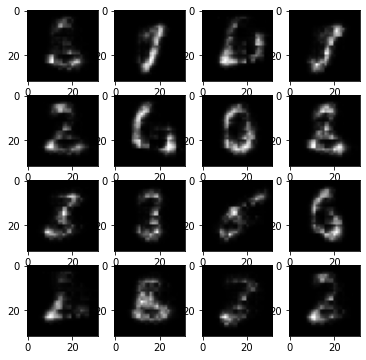

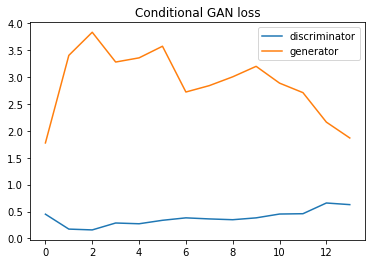

100%|██████████| 600/600 [00:35<00:00, 17.01it/s]


Epoch:15, Loss discriminator:0.6790
Epoch:15, Loss generator:2.0128


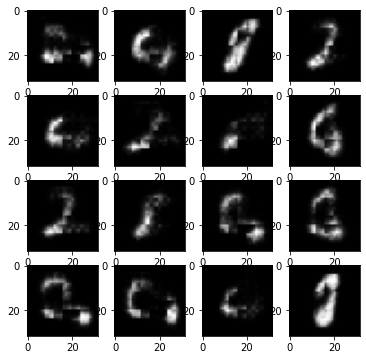

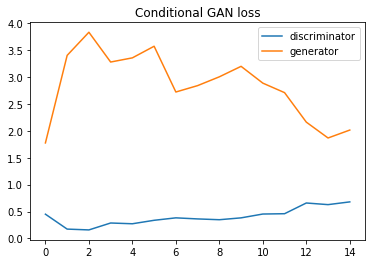

100%|██████████| 600/600 [00:34<00:00, 17.24it/s]


Epoch:16, Loss discriminator:0.7027
Epoch:16, Loss generator:2.0118


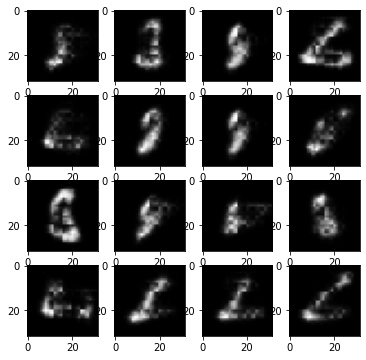

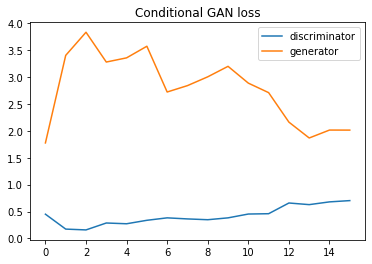

100%|██████████| 600/600 [00:35<00:00, 17.05it/s]


Epoch:17, Loss discriminator:0.7558
Epoch:17, Loss generator:1.9730


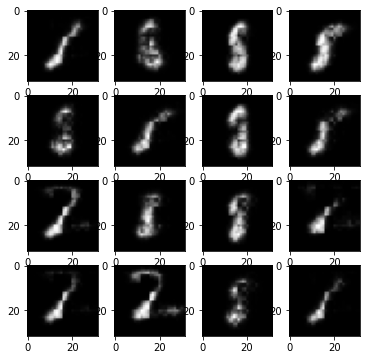

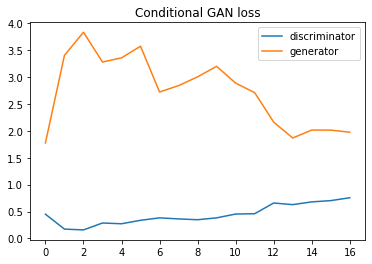

100%|██████████| 600/600 [00:35<00:00, 17.10it/s]


Epoch:18, Loss discriminator:0.8458
Epoch:18, Loss generator:1.5286


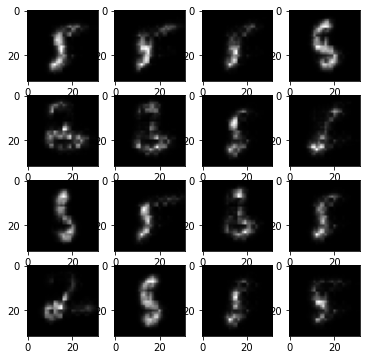

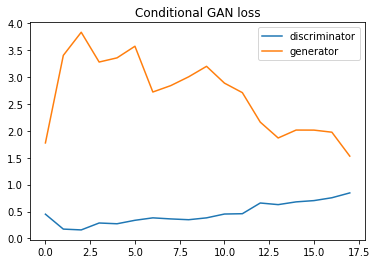

100%|██████████| 600/600 [00:34<00:00, 17.20it/s]


Epoch:19, Loss discriminator:0.8246
Epoch:19, Loss generator:1.6957


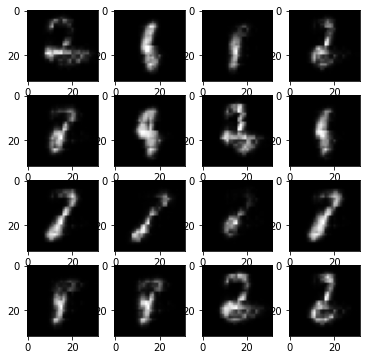

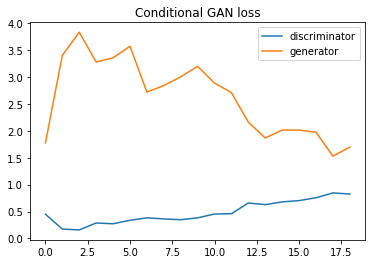

100%|██████████| 600/600 [00:34<00:00, 17.21it/s]


Epoch:20, Loss discriminator:0.9741
Epoch:20, Loss generator:1.7571


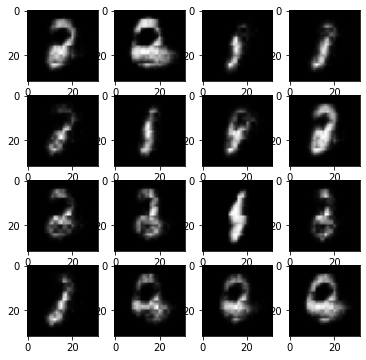

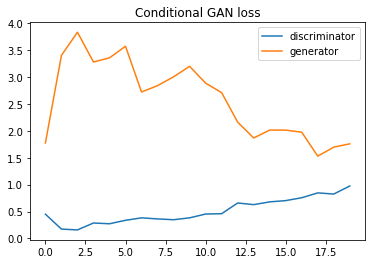

100%|██████████| 600/600 [00:35<00:00, 17.05it/s]


Epoch:21, Loss discriminator:0.8675
Epoch:21, Loss generator:1.6121


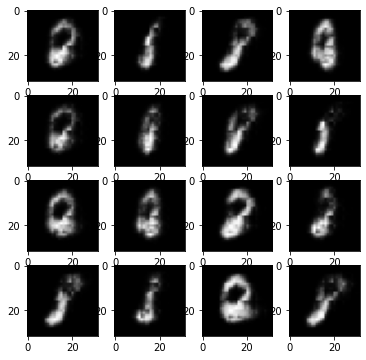

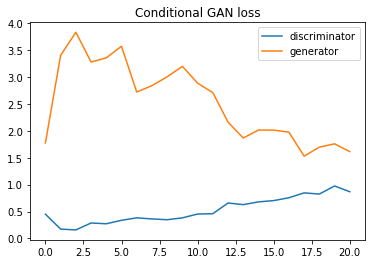

100%|██████████| 600/600 [00:35<00:00, 16.99it/s]


Epoch:22, Loss discriminator:0.8378
Epoch:22, Loss generator:1.5516


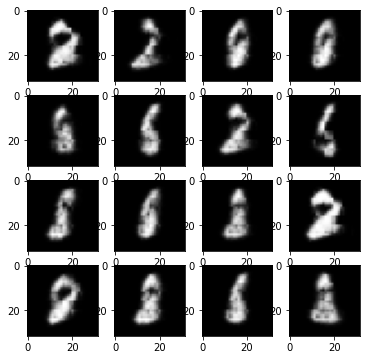

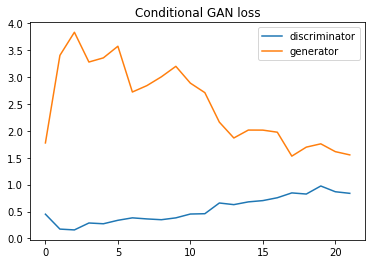

100%|██████████| 600/600 [00:35<00:00, 17.10it/s]


Epoch:23, Loss discriminator:0.8605
Epoch:23, Loss generator:1.7055


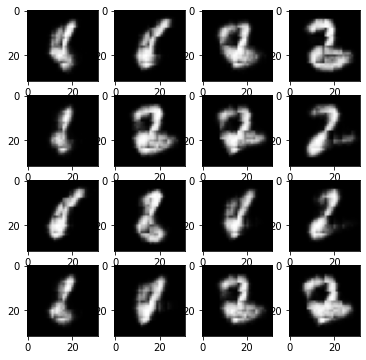

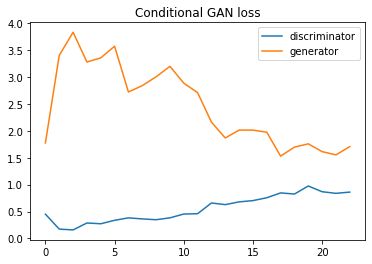

100%|██████████| 600/600 [00:34<00:00, 17.20it/s]


Epoch:24, Loss discriminator:0.8333
Epoch:24, Loss generator:1.8213


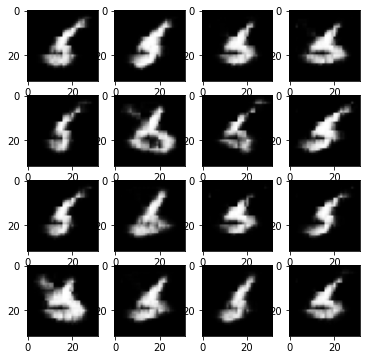

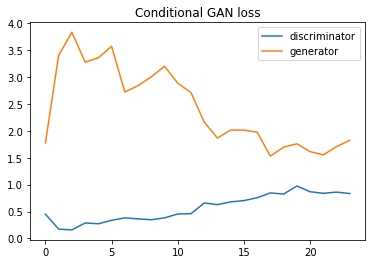

100%|██████████| 600/600 [00:35<00:00, 16.94it/s]


Epoch:25, Loss discriminator:0.8283
Epoch:25, Loss generator:1.9590


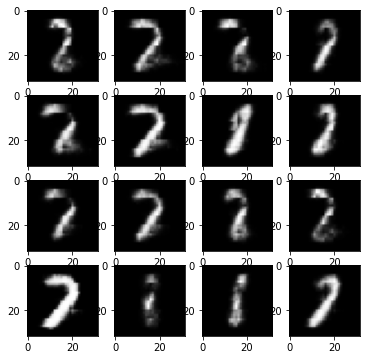

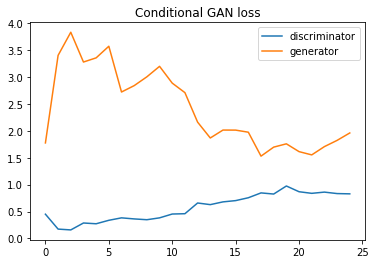

100%|██████████| 600/600 [00:36<00:00, 16.65it/s]


Epoch:26, Loss discriminator:0.9514
Epoch:26, Loss generator:1.4323


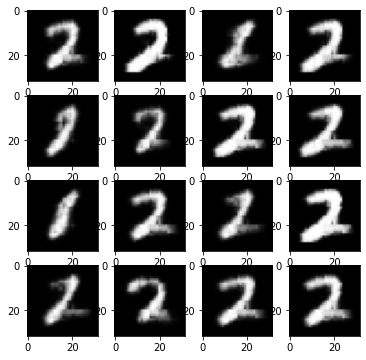

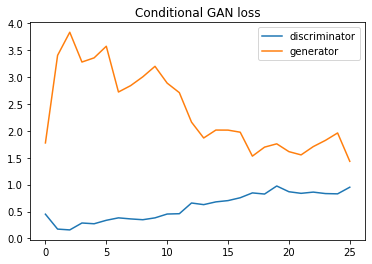

100%|██████████| 600/600 [00:35<00:00, 16.72it/s]


Epoch:27, Loss discriminator:1.0030
Epoch:27, Loss generator:1.2895


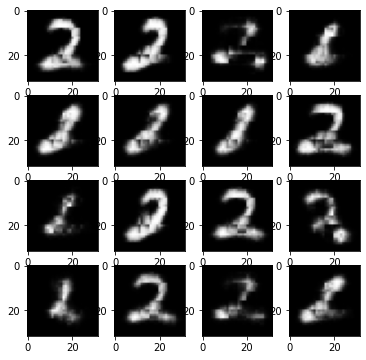

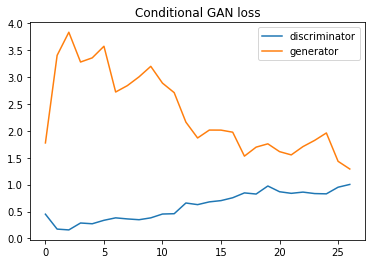

100%|██████████| 600/600 [00:35<00:00, 16.92it/s]


Epoch:28, Loss discriminator:0.9902
Epoch:28, Loss generator:1.3710


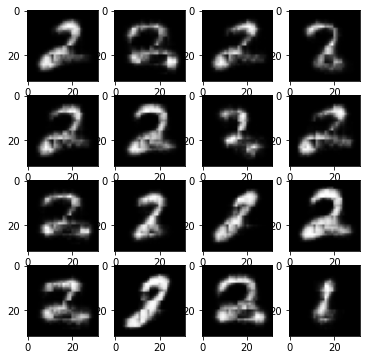

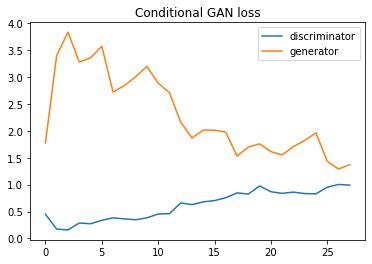

100%|██████████| 600/600 [00:35<00:00, 16.68it/s]


Epoch:29, Loss discriminator:1.0549
Epoch:29, Loss generator:1.2458


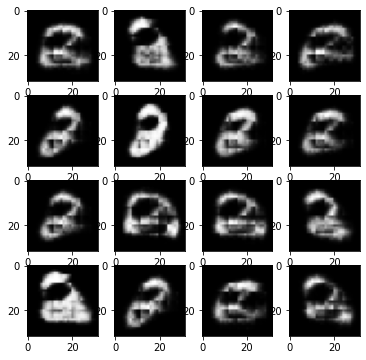

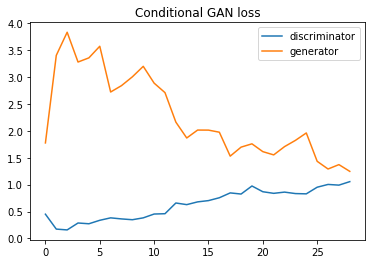

100%|██████████| 600/600 [00:36<00:00, 16.59it/s]


Epoch:30, Loss discriminator:1.0219
Epoch:30, Loss generator:1.2828


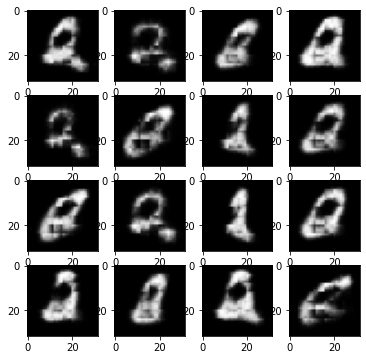

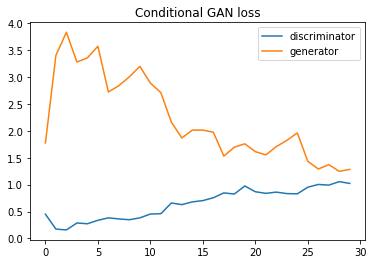

100%|██████████| 600/600 [00:36<00:00, 16.60it/s]


Epoch:31, Loss discriminator:1.0140
Epoch:31, Loss generator:1.3138


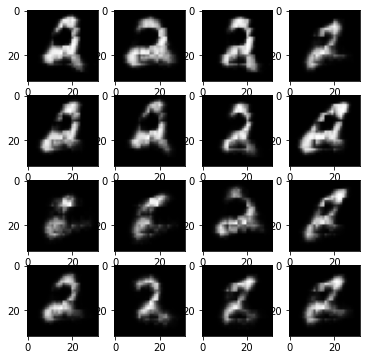

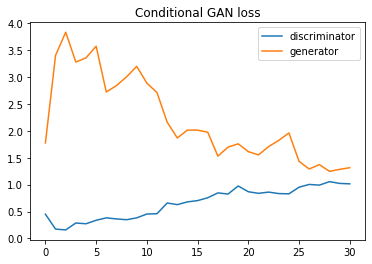

100%|██████████| 600/600 [00:36<00:00, 16.63it/s]


Epoch:32, Loss discriminator:1.0601
Epoch:32, Loss generator:1.2968


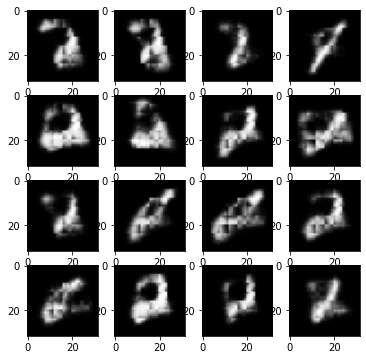

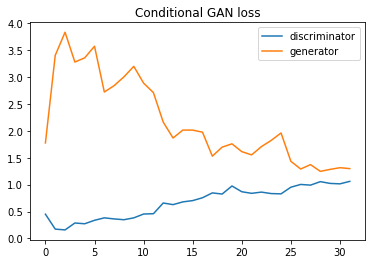

100%|██████████| 600/600 [00:36<00:00, 16.33it/s]


Epoch:33, Loss discriminator:1.0879
Epoch:33, Loss generator:1.2448


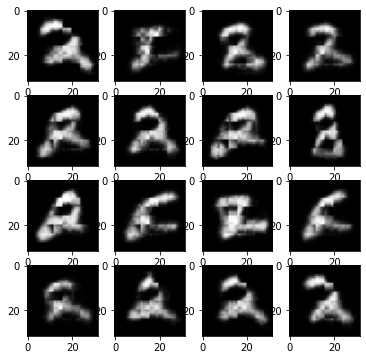

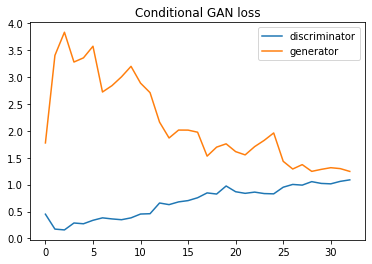

100%|██████████| 600/600 [00:37<00:00, 16.18it/s]


Epoch:34, Loss discriminator:1.1406
Epoch:34, Loss generator:1.1198


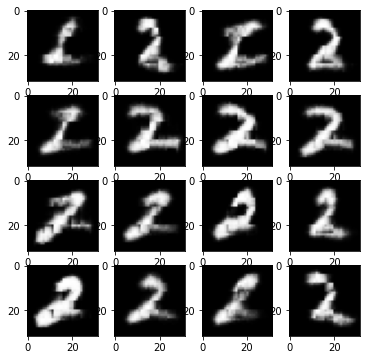

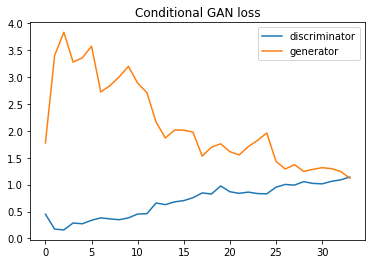

100%|██████████| 600/600 [00:36<00:00, 16.22it/s]


Epoch:35, Loss discriminator:1.1045
Epoch:35, Loss generator:1.1580


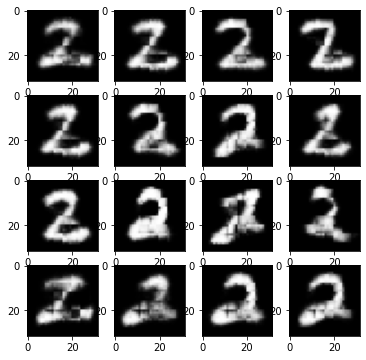

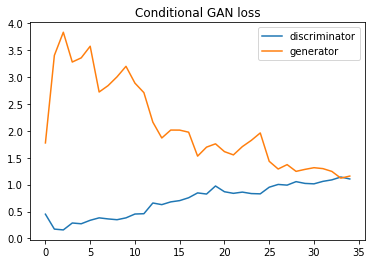

100%|██████████| 600/600 [00:37<00:00, 16.00it/s]


Epoch:36, Loss discriminator:1.1681
Epoch:36, Loss generator:1.0409


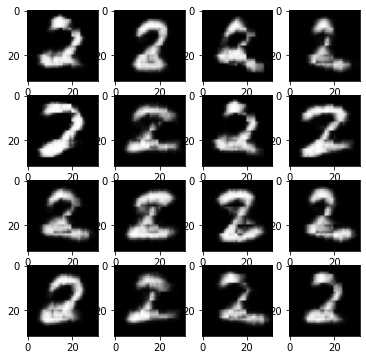

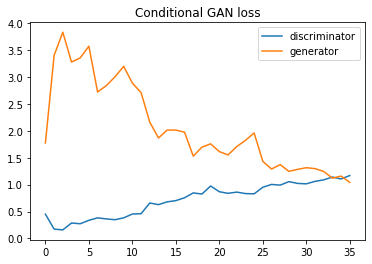

100%|██████████| 600/600 [00:37<00:00, 15.96it/s]


Epoch:37, Loss discriminator:1.1548
Epoch:37, Loss generator:1.0602


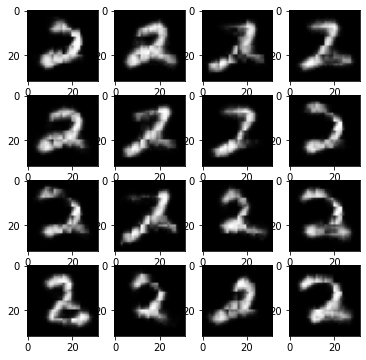

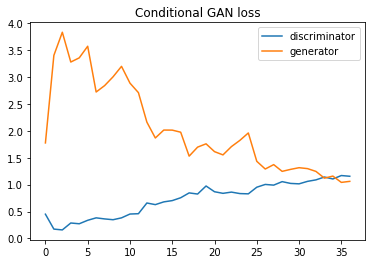

100%|██████████| 600/600 [00:37<00:00, 15.98it/s]


Epoch:38, Loss discriminator:1.1931
Epoch:38, Loss generator:1.0077


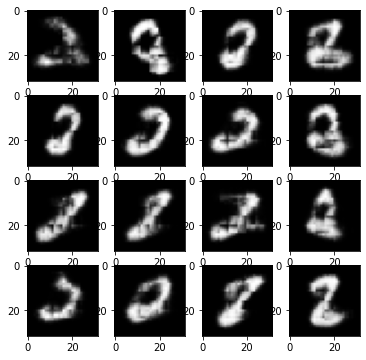

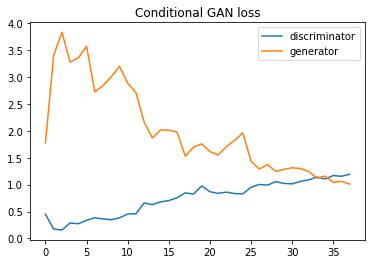

100%|██████████| 600/600 [00:37<00:00, 16.13it/s]


Epoch:39, Loss discriminator:1.1823
Epoch:39, Loss generator:1.0409


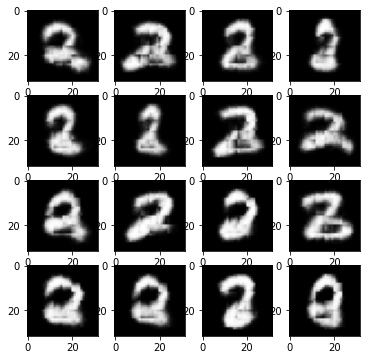

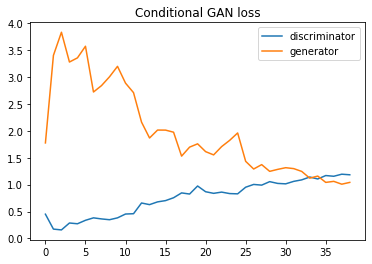

100%|██████████| 600/600 [00:37<00:00, 16.12it/s]


Epoch:40, Loss discriminator:1.2057
Epoch:40, Loss generator:1.0419


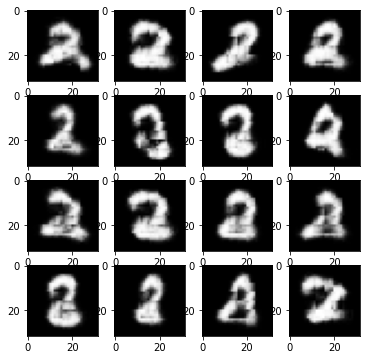

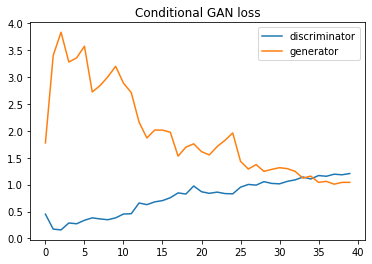

100%|██████████| 600/600 [00:37<00:00, 16.04it/s]


Epoch:41, Loss discriminator:1.2373
Epoch:41, Loss generator:0.9959


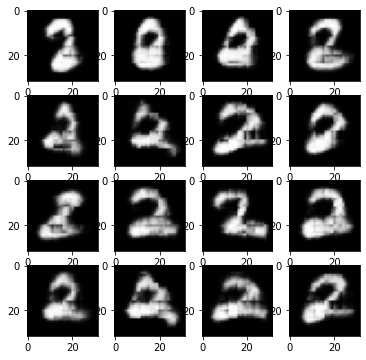

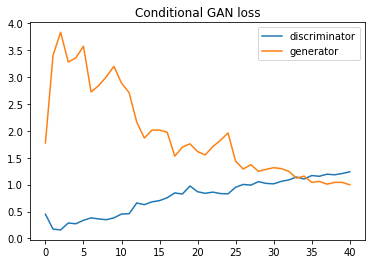

100%|██████████| 600/600 [00:37<00:00, 15.96it/s]


Epoch:42, Loss discriminator:1.2537
Epoch:42, Loss generator:0.9963


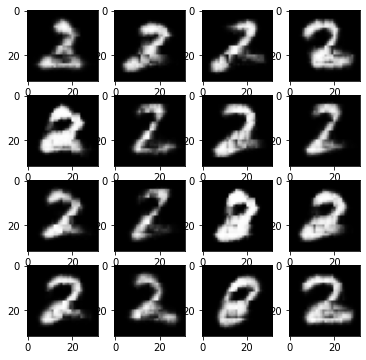

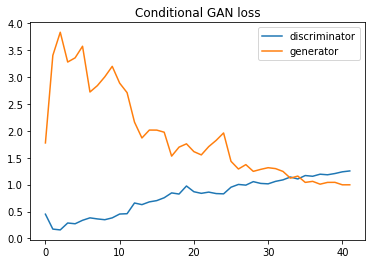

100%|██████████| 600/600 [00:37<00:00, 15.81it/s]


Epoch:43, Loss discriminator:1.2418
Epoch:43, Loss generator:0.9948


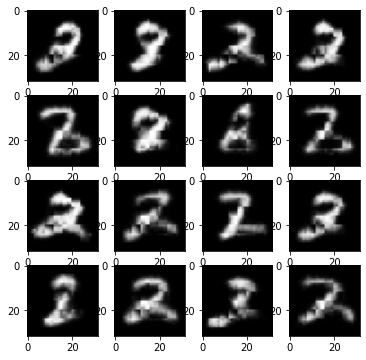

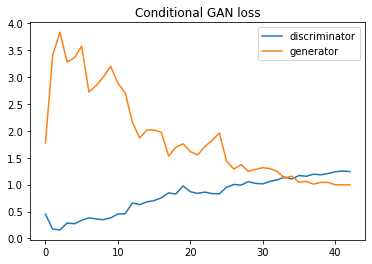

100%|██████████| 600/600 [00:38<00:00, 15.79it/s]


Epoch:44, Loss discriminator:1.2353
Epoch:44, Loss generator:0.9466


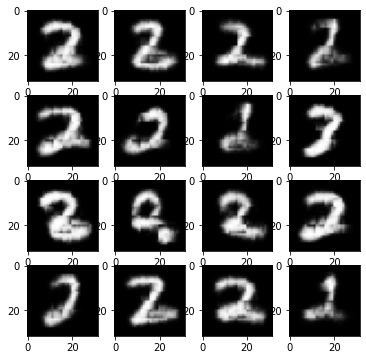

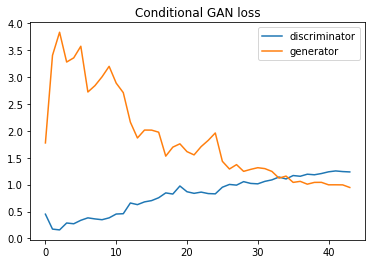

100%|██████████| 600/600 [00:38<00:00, 15.79it/s]


Epoch:45, Loss discriminator:1.2173
Epoch:45, Loss generator:0.9792


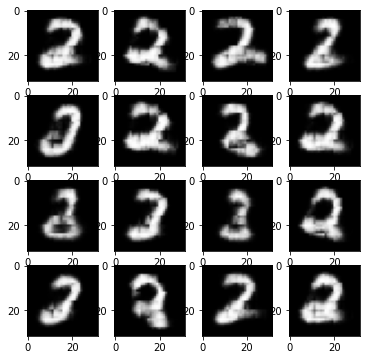

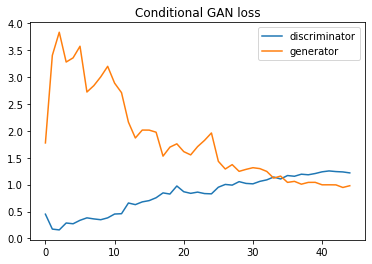

100%|██████████| 600/600 [00:38<00:00, 15.67it/s]


Epoch:46, Loss discriminator:1.1845
Epoch:46, Loss generator:1.0012


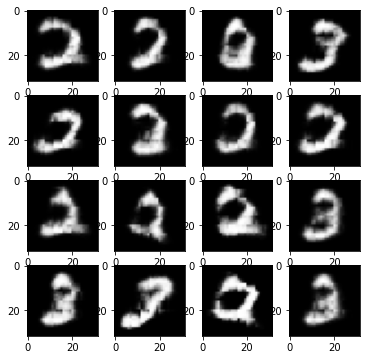

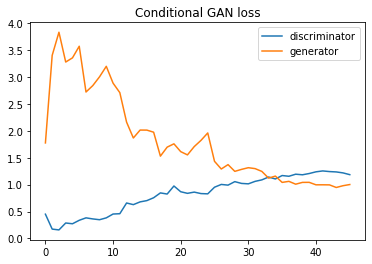

100%|██████████| 600/600 [00:38<00:00, 15.65it/s]


Epoch:47, Loss discriminator:1.2040
Epoch:47, Loss generator:0.9938


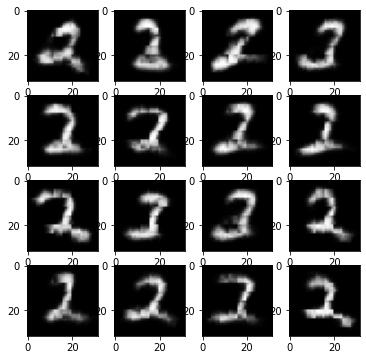

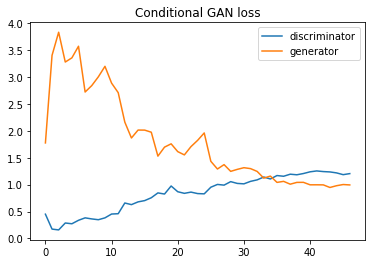

100%|██████████| 600/600 [00:38<00:00, 15.63it/s]


Epoch:48, Loss discriminator:1.1956
Epoch:48, Loss generator:1.0050


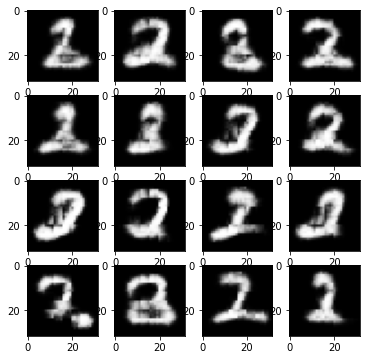

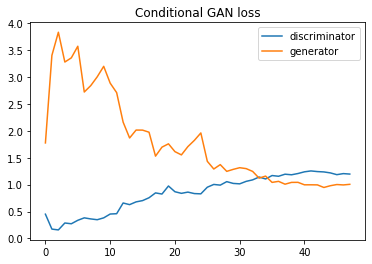

100%|██████████| 600/600 [00:38<00:00, 15.45it/s]


Epoch:49, Loss discriminator:1.2371
Epoch:49, Loss generator:0.9471


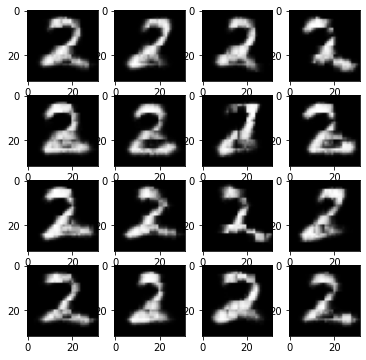

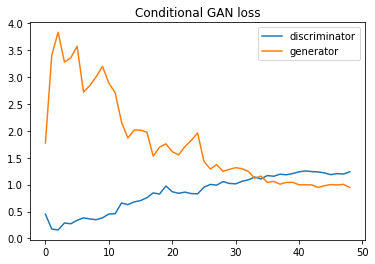

100%|██████████| 600/600 [00:38<00:00, 15.47it/s]


Epoch:50, Loss discriminator:1.2436
Epoch:50, Loss generator:0.9070


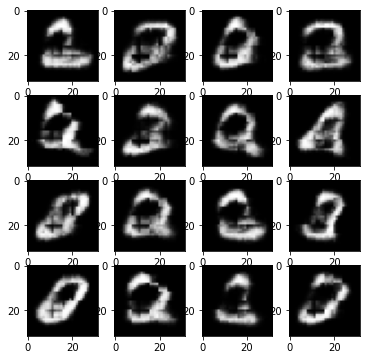

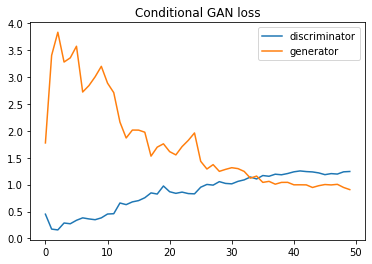

100%|██████████| 600/600 [00:38<00:00, 15.42it/s]


Epoch:51, Loss discriminator:1.2679
Epoch:51, Loss generator:0.8770


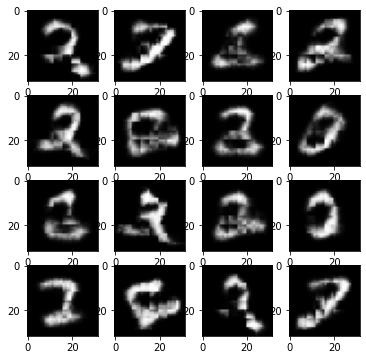

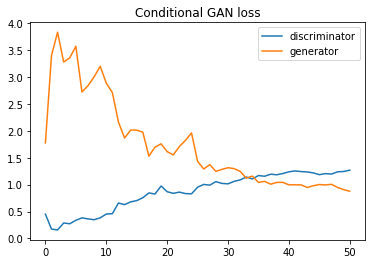

100%|██████████| 600/600 [00:39<00:00, 15.11it/s]


Epoch:52, Loss discriminator:1.2832
Epoch:52, Loss generator:0.8609


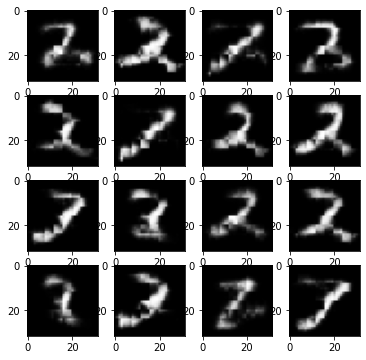

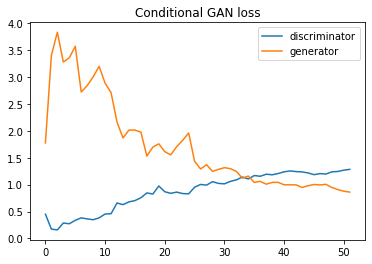

100%|██████████| 600/600 [00:39<00:00, 15.29it/s]


Epoch:53, Loss discriminator:1.2505
Epoch:53, Loss generator:0.8829


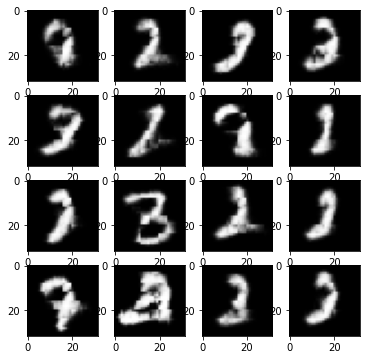

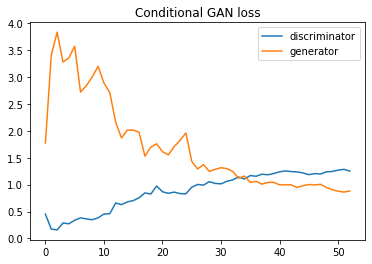

100%|██████████| 600/600 [00:39<00:00, 15.30it/s]


Epoch:54, Loss discriminator:1.2592
Epoch:54, Loss generator:0.8991


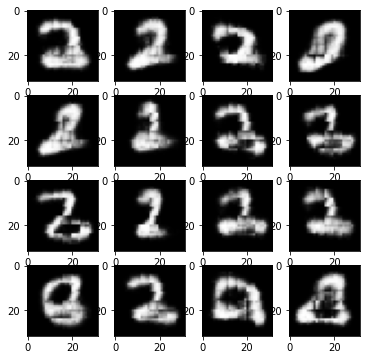

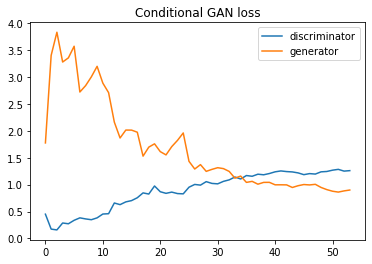

100%|██████████| 600/600 [00:39<00:00, 15.10it/s]


Epoch:55, Loss discriminator:1.2743
Epoch:55, Loss generator:0.8710


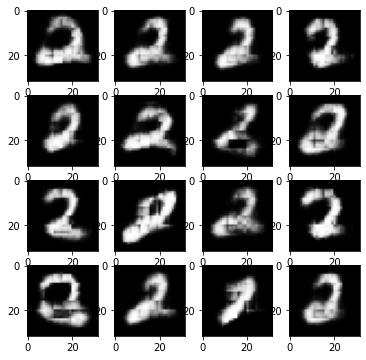

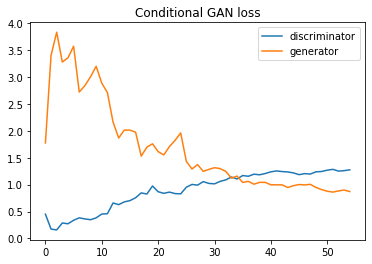

100%|██████████| 600/600 [00:39<00:00, 15.09it/s]


Epoch:56, Loss discriminator:1.2728
Epoch:56, Loss generator:0.8979


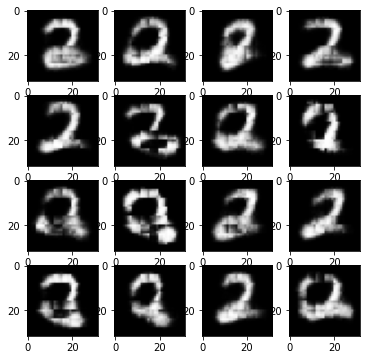

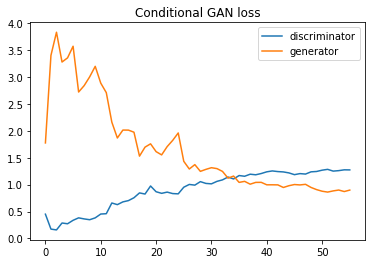

100%|██████████| 600/600 [00:39<00:00, 15.21it/s]


Epoch:57, Loss discriminator:1.2929
Epoch:57, Loss generator:0.8779


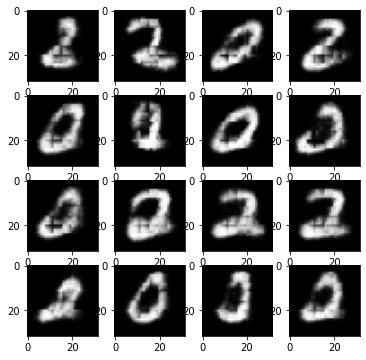

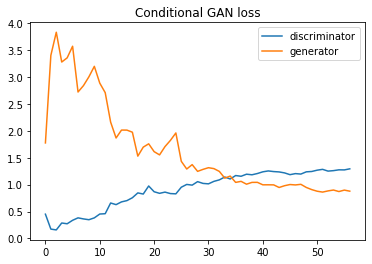

100%|██████████| 600/600 [00:40<00:00, 14.93it/s]


Epoch:58, Loss discriminator:1.2774
Epoch:58, Loss generator:0.8554


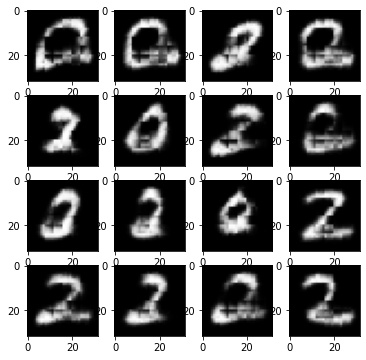

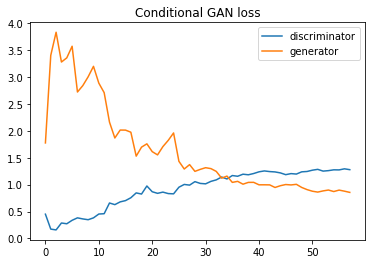

100%|██████████| 600/600 [00:40<00:00, 14.82it/s]


Epoch:59, Loss discriminator:1.2807
Epoch:59, Loss generator:0.8772


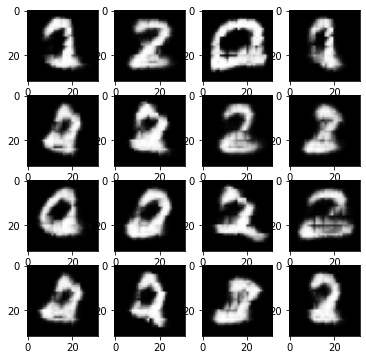

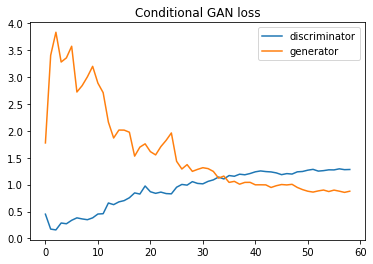

100%|██████████| 600/600 [00:40<00:00, 14.75it/s]


Epoch:60, Loss discriminator:1.2670
Epoch:60, Loss generator:0.8923


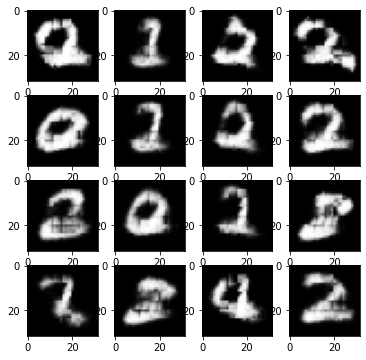

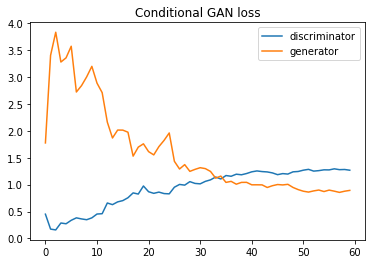

100%|██████████| 600/600 [00:40<00:00, 14.67it/s]


Epoch:61, Loss discriminator:1.2657
Epoch:61, Loss generator:0.9003


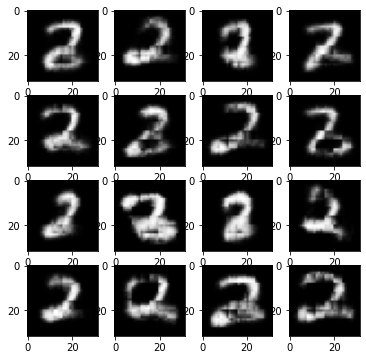

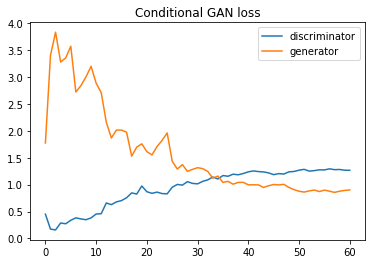

100%|██████████| 600/600 [00:41<00:00, 14.62it/s]


Epoch:62, Loss discriminator:1.3062
Epoch:62, Loss generator:0.8803


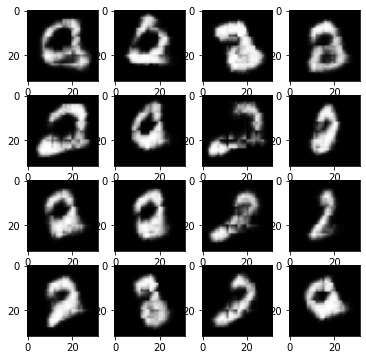

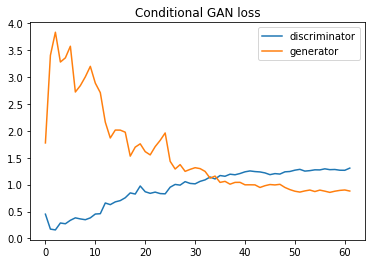

100%|██████████| 600/600 [00:41<00:00, 14.51it/s]


Epoch:63, Loss discriminator:1.3270
Epoch:63, Loss generator:0.8121


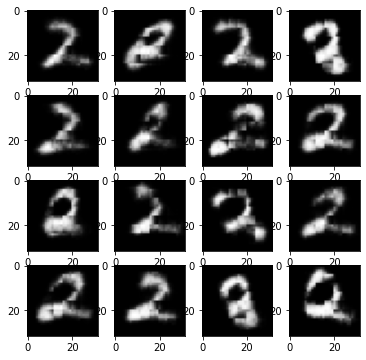

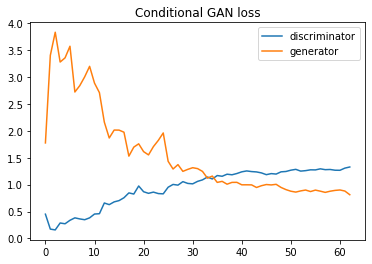

100%|██████████| 600/600 [00:41<00:00, 14.49it/s]


Epoch:64, Loss discriminator:1.3341
Epoch:64, Loss generator:0.7881


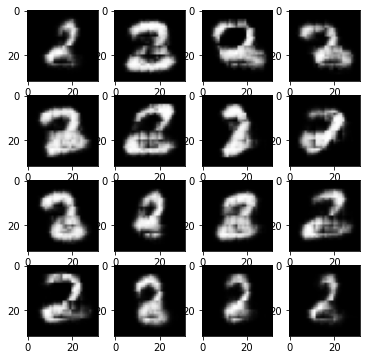

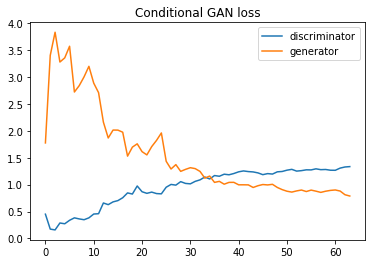

100%|██████████| 600/600 [00:41<00:00, 14.42it/s]


Epoch:65, Loss discriminator:1.3277
Epoch:65, Loss generator:0.8280


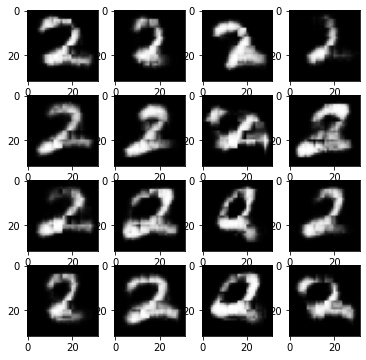

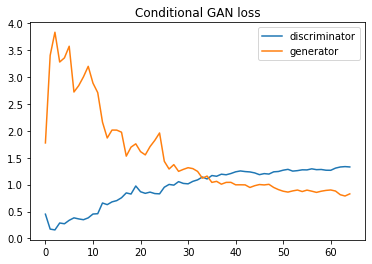

100%|██████████| 600/600 [00:41<00:00, 14.38it/s]


Epoch:66, Loss discriminator:1.3408
Epoch:66, Loss generator:0.7854


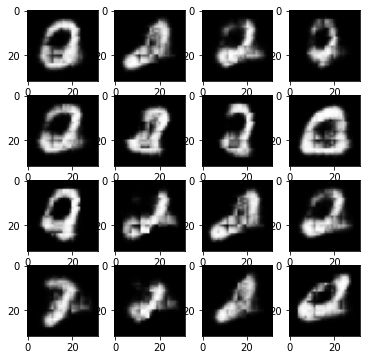

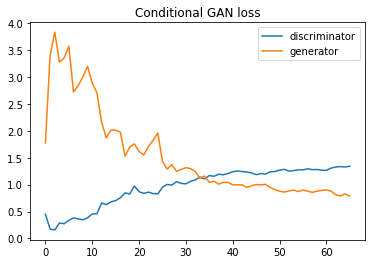

100%|██████████| 600/600 [00:41<00:00, 14.32it/s]


Epoch:67, Loss discriminator:1.3177
Epoch:67, Loss generator:0.7882


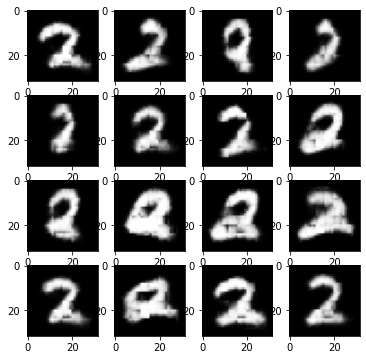

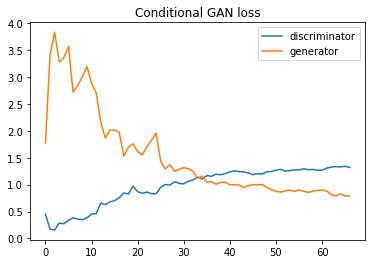

100%|██████████| 600/600 [00:42<00:00, 14.18it/s]


Epoch:68, Loss discriminator:1.3320
Epoch:68, Loss generator:0.7853


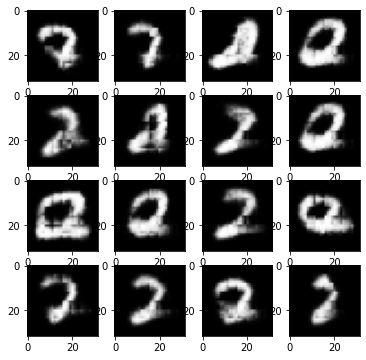

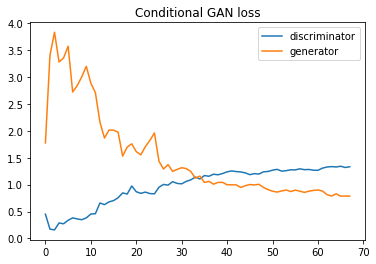

100%|██████████| 600/600 [00:42<00:00, 14.24it/s]


Epoch:69, Loss discriminator:1.3131
Epoch:69, Loss generator:0.8106


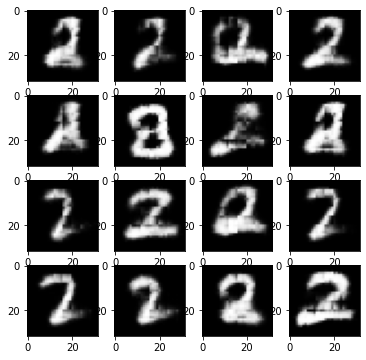

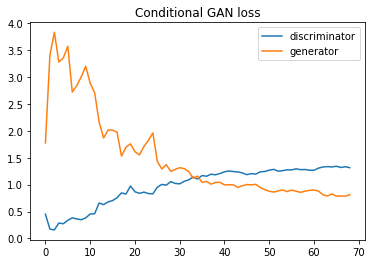

100%|██████████| 600/600 [00:41<00:00, 14.29it/s]


Epoch:70, Loss discriminator:1.3036
Epoch:70, Loss generator:0.8447


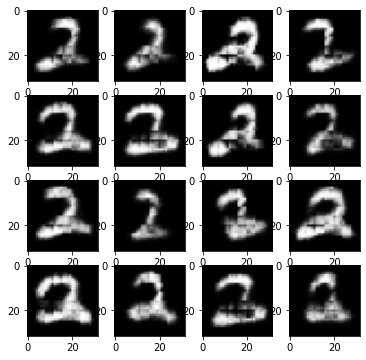

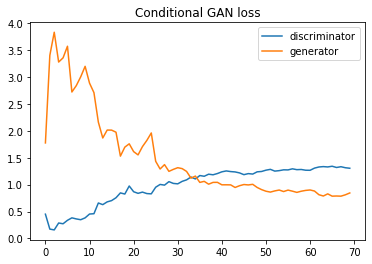

100%|██████████| 600/600 [00:42<00:00, 14.16it/s]


Epoch:71, Loss discriminator:1.3044
Epoch:71, Loss generator:0.8166


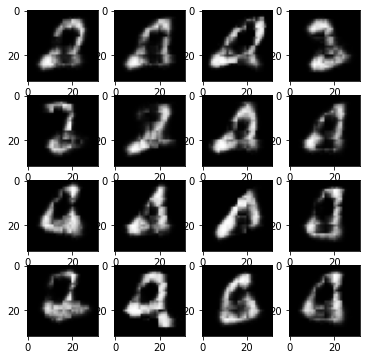

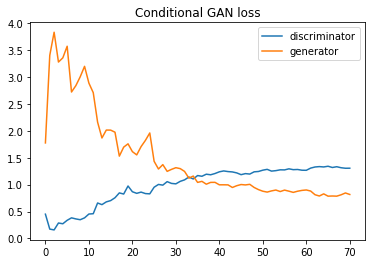

100%|██████████| 600/600 [00:42<00:00, 14.16it/s]


Epoch:72, Loss discriminator:1.3029
Epoch:72, Loss generator:0.8308


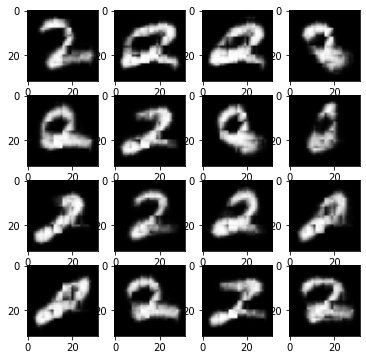

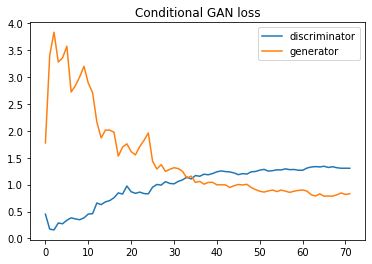

100%|██████████| 600/600 [00:42<00:00, 14.14it/s]


Epoch:73, Loss discriminator:1.3382
Epoch:73, Loss generator:0.7891


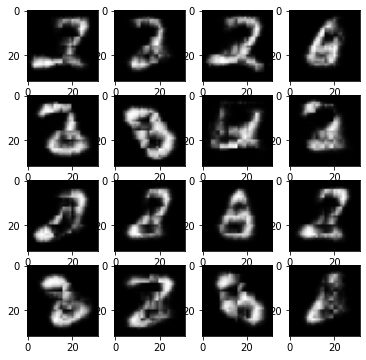

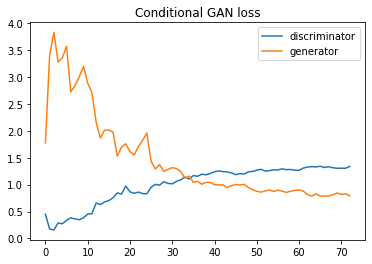

100%|██████████| 600/600 [00:42<00:00, 14.12it/s]


Epoch:74, Loss discriminator:1.3115
Epoch:74, Loss generator:0.8084


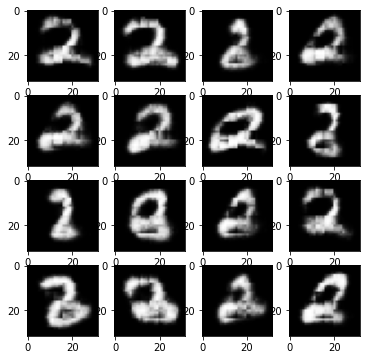

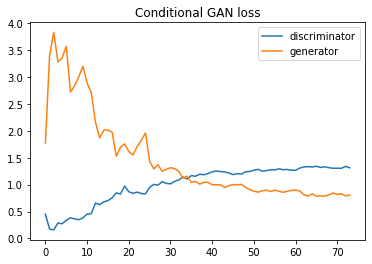

100%|██████████| 600/600 [00:42<00:00, 14.21it/s]


Epoch:75, Loss discriminator:1.3428
Epoch:75, Loss generator:0.7746


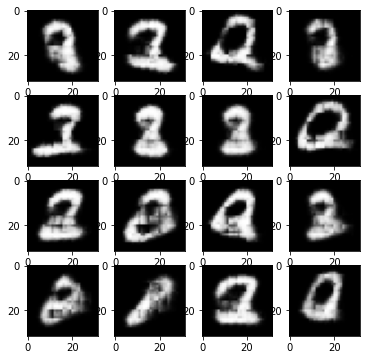

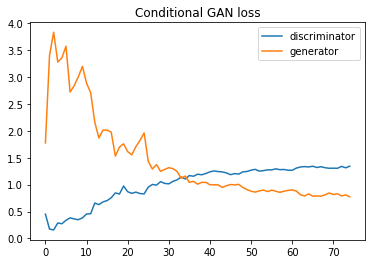

100%|██████████| 600/600 [00:42<00:00, 14.10it/s]


Epoch:76, Loss discriminator:1.3199
Epoch:76, Loss generator:0.7858


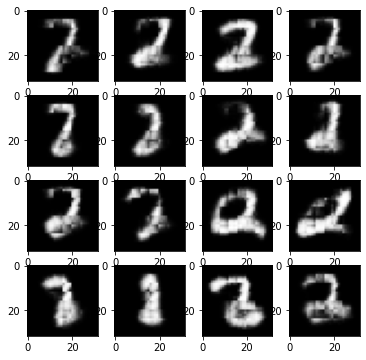

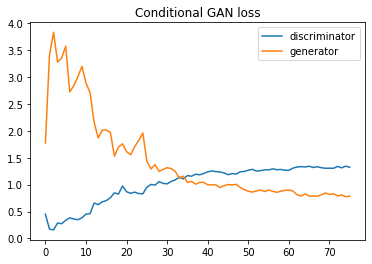

100%|██████████| 600/600 [00:43<00:00, 13.93it/s]


Epoch:77, Loss discriminator:1.3072
Epoch:77, Loss generator:0.8064


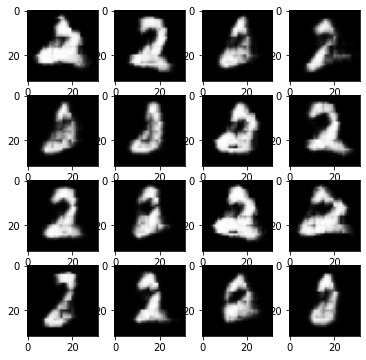

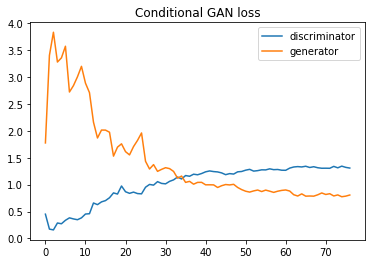

 56%|█████▌    | 333/600 [00:23<00:19, 13.98it/s]


KeyboardInterrupt: ignored

In [ ]:
batch_size=100


def generate_fake_labels(number_of_images=batch_size):
    return torch.randint(0, 10, (number_of_images,))


def train_epoch(generator, discriminator, encoder, loss_function, generator_optimizer, discriminator_optimizer):
    real_label, fake_label = 1.0, 0.0
    loss_dis = 0.0
    loss_gen = 0.0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainset)/trainloader.batch_size)):
        # train discriminator
        discriminator.zero_grad()
        img, digit_labels = data
        real_images = encoder(img)
        label = torch.full((img.shape[0],1), real_label)
        output = discriminator(real_images, digit_labels)
        error_real_images = loss_function(output, label)
        error_real_images.backward()
        D_x = output.mean().item()

        latent = generate_latent(img.shape[0])
        fake_digit_label = generate_fake_labels()
        fake = generator(latent, fake_digit_label)
        output = discriminator(fake.detach(), fake_digit_label)
        label.fill_(fake_label)
        error_fake_images = loss_function(output, label)
        error_fake_images.backward()
        D_G_z1 = output.mean().item()
        errD = error_real_images + error_fake_images
        discriminator_optimizer.step()

        # train generator
        generator.zero_grad()
        generated_data = generator(latent, fake_digit_label)
        output = discriminator(generated_data, fake_digit_label)
        label.fill_(real_label)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        loss_dis += errD
        loss_gen += errG
        counter += 1
    return loss_dis / counter, loss_gen / counter


def train(generator, discriminator, num_epochs=30, lr_discriminator=1e-3, lr_generator=1e-3, trainset=trainset, train_loader=trainloader):
    loss_discriminator = []
    loss_generator = []
    torch.manual_seed(42)
    encoder = Encoder()
    encoder.load_state_dict(copy.deepcopy(torch.load("encoder_model_14.pth", device)))
    criterion = nn.BCELoss()
    generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator, lr_generator, lr_discriminator)
    for epoch in range(num_epochs):
        loss_dis, loss_gen = train_epoch(generator, discriminator, encoder, criterion, generator_optimizer, discriminator_optimizer)
        print('Epoch:{}, Loss discriminator:{:.4f}'.format(epoch+1, loss_dis))
        print('Epoch:{}, Loss generator:{:.4f}'.format(epoch+1, loss_gen))
        loss_discriminator.append(loss_dis)
        loss_generator.append(loss_gen)
        generate_images(generator)

        plt.plot(loss_discriminator)
        plt.plot(loss_generator)
        plt.title('Conditional GAN loss')
        plt.legend(['discriminator', 'generator'])
        plt.show()
        torch.save(generator.state_dict(), 'cond_generator.pth')
    print(loss_discriminator, loss_generator)
    plt.plot(loss_discriminator)
    plt.plot(loss_generator)
    plt.title('Conditional GAN loss')
    plt.legend(['discriminator', 'generator'])
    plt.show()
    
    


generator = ConditionalGenerator()
discriminator = ConditionalDiscriminator()

def generate_images(generator):
    decoder = Decoder()
    decoder.load_state_dict(copy.deepcopy(torch.load("decoder_model_14.pth", device)))

    labels = generate_specific_digit(digit_to_generate=2)
    latents = generate_latent()
    generate_images = generator(latents, labels)
    # print("Generate images: ", generate_images)
    outputs = decoder(generate_images[:16])

    plt.figure(figsize=(4, 4))
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    recon = outputs.detach().numpy()
    for i, item in enumerate(recon):
        if i >= 16: break
        plt.subplot(4, 4, 0+i+1)
        plt.imshow(item[0], cmap='gray')

    plt.show()


num_epochs = 120
train(generator, discriminator, num_epochs, lr_discriminator=0.0003, lr_generator=0.0003)

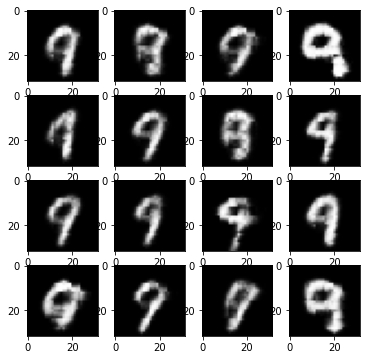

In [ ]:

def generate_images(generator):
    decoder = Decoder()
    decoder.load_state_dict(copy.deepcopy(torch.load("decoder_model_14.pth", device)))

    labels = generate_specific_digit(digit_to_generate=9)
    latents = generate_latent()
    generate_images = generator(latents, labels)
    # print("Generate images: ", generate_images)
    outputs = decoder(generate_images[:16])

    plt.figure(figsize=(4, 4))
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    recon = outputs.detach().numpy()
    for i, item in enumerate(recon):
        if i >= 16: break
        plt.subplot(4, 4, 0+i+1)
        plt.imshow(item[0], cmap='gray')

    plt.show()

generator = ConditionalGenerator()
generator.load_state_dict(copy.deepcopy(torch.load("cond_generator.pth", device)))
generate_images(generator)